In [1]:
import json
import pandas as pd
import numpy as np
from noggin import create_plot
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext

In [3]:
file_path1 = r"C:\Users\ejian\CogWorks-2022-Gausslien-Final-Capstone\Sarcasm Detector\Sarcasm_Headlines_Dataset.json"
df = pd.read_json(file_path1,lines=True)
df = df[['headline','is_sarcastic']]
#print(df[:50])

In [4]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [5]:
x = np.asarray(df)

In [6]:
x.shape

(26709, 2)

In [7]:
x[:,1]

array([0, 0, 1, ..., 0, 0, 0], dtype=object)

In [8]:
import random
import numpy as np

def train_split(data, validation=0.2):
    N = len(data)
    print(N)
    breakpoint = int(validation*N)
    
    data_idxs = list(np.arange(N))
    
    random.shuffle(data_idxs)
    #print(data_idxs)
    
    return data[data_idxs[:breakpoint], :], data[data_idxs[breakpoint:], :]

In [9]:
testing_data, training_data = train_split(x)

26709


In [10]:
testing_data.shape
testing_data

array([['deadly suicide blast hits afghan capital', 0],
       ["what selma blair's 'outburst' teaches us about mixing pills and alcohol",
        0],
       ['model railroading a harsh mistress', 1],
       ...,
       ["dogs smell grandma's scent, set off on quest to find her", 0],
       ['obama leaves post-it on counter with quick note explaining how to use extralegal surveillance apparatus',
        1],
       ['physically fit, emotionally stable kim jong-un addresses un after finally getting nuclear ambitions out of system',
        1]], dtype=object)

In [11]:
training_data

array([['congress establishes bill suggestion hotline', 1],
       ["everest avalanche victim's loved ones launch campaign dedicated to 'living life as an adventure'",
        0],
       ["nation's legislators resume unfettered whoring", 1],
       ...,
       ["let's not forget that men have impeccable winter style, too", 0],
       ['kool-aid, hi-c make backroom deal to destroy tang', 1],
       ["photos of janet jackson's style evolution through the years", 0]],
      dtype=object)

In [12]:
training_data.shape

(21368, 2)

In [13]:
#tokenizer stuff
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

def tokenize(data):
    tokens = [tokenizer(headline) for headline in data[:, 0]]
    return tokens

In [14]:
tokenizedTrainingData = tokenize(training_data)
tokenizedTestingData = tokenize(testing_data)

In [15]:
#tokenizedTrainingData

[['congress', 'establishes', 'bill', 'suggestion', 'hotline'],
 ['everest',
  'avalanche',
  'victim',
  "'",
  's',
  'loved',
  'ones',
  'launch',
  'campaign',
  'dedicated',
  'to',
  "'",
  'living',
  'life',
  'as',
  'an',
  'adventure',
  "'"],
 ['nation', "'", 's', 'legislators', 'resume', 'unfettered', 'whoring'],
 ['wal-mart', 'announces', 'plan', 'to', 'slash', 'customers', "'", 'throats'],
 ["'",
  'it',
  "'",
  's',
  'real',
  'easy',
  ',',
  "'",
  'declares',
  'it',
  'guy',
  'about',
  'to',
  'speak',
  'incoherently',
  'for',
  'next',
  '30',
  'seconds'],
 ['stephen',
  'curry',
  'apologizes',
  'for',
  'being',
  'better',
  'than',
  'everyone',
  'else'],
 ['no',
  ',',
  'donald',
  'trump',
  'isn',
  "'",
  't',
  'doing',
  'what',
  'al',
  'gore',
  'did',
  'in',
  '2000'],
 ['if',
  'the',
  'presidential',
  'election',
  'were',
  'held',
  'tomorrow',
  ',',
  'i',
  "'",
  'd',
  'shoot',
  'myself'],
 ['last',
  'beer',
  'in',
  'six',
  

In [16]:
trainingVocab = torchtext.vocab.build_vocab_from_iterator(tokenizedTrainingData)

In [17]:
vocabArr = np.array([word for word in trainingVocab.get_stoi().keys()])

In [18]:
len(vocabArr)

24990

In [80]:
class Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx):
        super().__init__()
#         self.embed = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.LSTM = nn.LSTM(embedding_dim, hidden_dim, num_layers = n_layers, dropout = dropout, bidirectional = True, batch_first = True)
        self.Linear = nn.Linear(hidden_dim*2, output_dim)
#         self.Dropout = nn.dropout(dropout = dropout)
        
    def forward(self, text, text_length):
#         embedding = self.embed(text)
        
        packedEmbeddings = torch.nn.utils.rnn.pack_padded_sequence(text, text_length, batch_first = True)
        packedOutput, (hidden, cell) = self.LSTM(packedEmbeddings)
#         unpackedOutput, unpackedLength = torch.nn.utils.rnn.pad_packed_sequence(packedOutput)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        return self.Linear(hidden)
 

In [81]:
vocab_size = len(vocabArr)
embedding_dim = 100 # was 200
hidden_dim = 256 #was 10
output_dim = 1
n_layers = 2
dropout = 0.5
pad_idx = 0 #change

model = Model(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pad_idx)

In [41]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    return correct.sum() / len(correct)


In [82]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters()) 

In [43]:
sigmoidBCE = nn.BCEWithLogitsLoss()

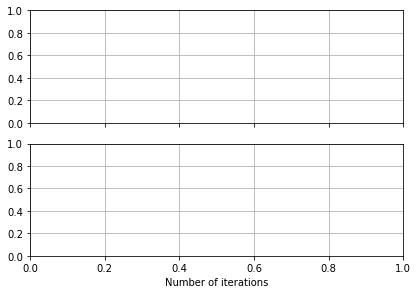

In [44]:
plotter, fig, ax = create_plot(["loss", "accuracy"])


In [25]:
training_data

array([['congress establishes bill suggestion hotline', 1],
       ["everest avalanche victim's loved ones launch campaign dedicated to 'living life as an adventure'",
        0],
       ["nation's legislators resume unfettered whoring", 1],
       ...,
       ["let's not forget that men have impeccable winter style, too", 0],
       ['kool-aid, hi-c make backroom deal to destroy tang', 1],
       ["photos of janet jackson's style evolution through the years", 0]],
      dtype=object)

In [26]:
vec = torchtext.vocab.GloVe(name = '6B', dim = 100)

In [27]:
trainingEmbeddings = [vec.get_vecs_by_tokens(sentence).tolist() for sentence in tokenizedTrainingData]
testingEmbeddings = [vec.get_vecs_by_tokens(sentence).tolist() for sentence in tokenizedTestingData]


In [28]:
# trainingEmbeddings[0:5]

[[[-0.09664399921894073,
   0.13989000022411346,
   1.1354999542236328,
   0.22782999277114868,
   0.23969000577926636,
   -0.12178999930620193,
   -1.1150000095367432,
   0.5055199861526489,
   -0.10414999723434448,
   -0.8720600008964539,
   0.660290002822876,
   -0.5194900035858154,
   -0.4437299966812134,
   -0.34595999121665955,
   -0.849370002746582,
   0.4256899952888489,
   0.438510000705719,
   0.49656999111175537,
   -0.4678100049495697,
   -1.0053999423980713,
   0.505050003528595,
   -0.38760000467300415,
   0.5956599712371826,
   -0.5319399833679199,
   -1.200700044631958,
   -0.12272000312805176,
   -0.5212699770927429,
   -0.5824099779129028,
   0.18893000483512878,
   -0.3003000020980835,
   0.7556999921798706,
   0.9757599830627441,
   0.2069000005722046,
   -0.30671000480651855,
   -0.6937699913978577,
   0.5494999885559082,
   -0.20052999258041382,
   -0.16760000586509705,
   0.0263069998472929,
   0.7187399864196777,
   -1.184999942779541,
   -0.3655500113964081,
  

In [111]:
training_max_length = max(len(sentence) for sentence in trainingEmbeddings)
testing_max_length = max(len(sentence) for sentence in testingEmbeddings)

max_length = max(training_max_length, testing_max_length)

training_padded = np.zeros((len(trainingEmbeddings), max_length, 100))

for sentence_idx in range(len(trainingEmbeddings)):
    sentence = trainingEmbeddings[sentence_idx]
    for word_idx in range(len(trainingEmbeddings[sentence_idx])):
        word = sentence[word_idx]
        training_padded[sentence_idx][word_idx] = word


In [112]:
testing_padded = np.zeros((len(testingEmbeddings), max_length, 100))

for sentence_idx in range(len(testingEmbeddings)):
    sentence = testingEmbeddings[sentence_idx]
    for word_idx in range(len(testingEmbeddings[sentence_idx])):
        word = sentence[word_idx]
        testing_padded[sentence_idx][word_idx] = word

In [ ]:
num_epochs = 10
batch_size = 100
# print(training_data.shape)
for epoch in range(num_epochs):
    print(epoch)
    idxs = np.arange(len(training_data))  # -> array([0, 1, ..., num_train-1])
    np.random.shuffle(idxs)  # shuffles indices in-place
    
    for batch_cnt in range(len(training_data) // batch_size):
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]
#         print(training_data.shape)
#         print(training_data[batch_indices])
        batch = training_padded[batch_indices]  # <COGSTUB> get the random batch of our training data
        truth = training_data[batch_indices][:, 1] # <COGSTUB> get the true labels for this batch of images
        truth = np.vstack(truth).astype(np.float)

#         print(batch)
#         truth = np.reshape(truth, (100, 1))
#         print(truth.shape)
        text_lengths = [len(sentence) for sentence in batch]
        training_paddedArr = torch.from_numpy(training_padded)
        prediction = model(torch.tensor(batch, dtype = torch.float32), torch.tensor(text_lengths))
#         prediction = torch.reshape(prediction, (100,))
        
        
#         print(prediction.shape)
#         print(prediction)
#         print(truth.shape)
#         print(type(truth[0]))
    
        
        loss = sigmoidBCE(prediction, torch.from_numpy(truth))
        print("Training Loss: " + loss)

        loss.backward()
        optimizer.step()
        acc = binary_accuracy(prediction, torch.tensor(truth, dtype = torch.float32))
        print("Training accuracy: " + acc)

        plotter.set_train_batch(
            {"loss": loss.item(), "accuracy": acc}, batch_size=batch_size
        )
    
      # Here, we evaluate our model on batches of *testing* data
    # this will show us how good our model does on data that
    # it has never encountered
    # Iterate over batches of *testing* data
    for batch_cnt in range(0, len(testing_data) // batch_size):
        idxs = np.arange(len(testing_data))
        batch_indices = idxs[batch_cnt * batch_size : (batch_cnt + 1) * batch_size]  # <COGSTUB>  get the batch of our **test** data
        batch = testing_padded[batch_indices]  # <COGSTUB>  get the batch of our **test** labels

        with torch.no_grad():
            # get your model's prediction on the test-batch
            text_lengths = [len(sentence) for sentence in batch]
            prediction = model(torch.tensor(batch, dtype = torch.float32),  torch.tensor(text_lengths))

            # get the truth values for that test-batch
            truth = training_data[batch_indices][:, 1] # <COGSTUB> get the true labels for this batch of images
            truth = np.vstack(truth).astype(np.float)

            # compute the test accuracy
            acc = binary_accuracy(prediction, torch.tensor(truth, dtype = torch.float32))
            print("Validation accuracy: " + acc)

        # log the test-accuracy in noggin
        plotter.set_test_batch({"accuracy": acc}, batch_size=batch_size)

    plotter.set_train_epoch()
    plotter.set_test_epoch()
plotter.plot()    